In [42]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [3]:
# load the example image
image = cv2.imread("example.jpg")
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)

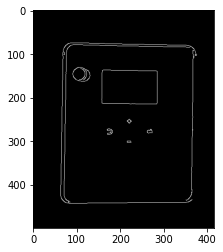

In [5]:
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [6]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [9]:
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

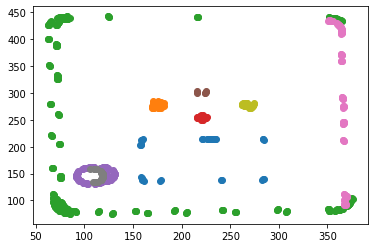

In [11]:
for c in cnts:
    x = [elem[0][0] for elem in c]
    y = [elem[0][1] for elem in c]
    plt.scatter(x, y)

[[[159 138]]

 [[158 213]]

 [[284 215]]

 [[285 140]]]


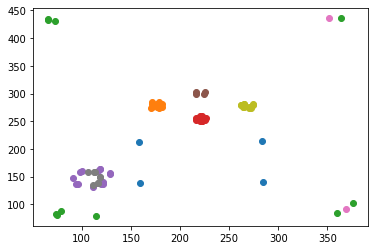

In [36]:
displayCnt = None
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has four vertices, then we have found
    # the thermostat display
    x = [elem[0][0] for elem in approx]
    y = [elem[0][1] for elem in approx]
    plt.scatter(x, y)
    if len(approx) == 4:
        if displayCnt is None:
            displayCnt = approx
            print(approx)
        #breakb

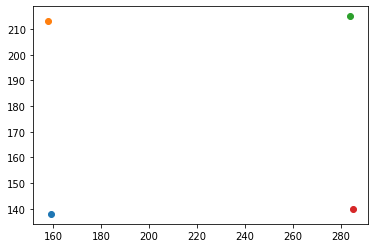

In [35]:
for elem in displayCnt:
    plt.scatter(elem[0][0], elem[0][1])

In [50]:
print(np.shape(displayCnt))
print(displayCnt)
print(displayCnt.reshape(4, 2))
print(displayCnt.reshape(2, 4))

(4, 1, 2)
[[[159 138]]

 [[158 213]]

 [[284 215]]

 [[285 140]]]
[[159 138]
 [158 213]
 [284 215]
 [285 140]]
[[159 138 158 213]
 [284 215 285 140]]


In [51]:
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

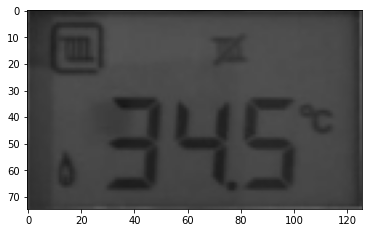

In [62]:
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

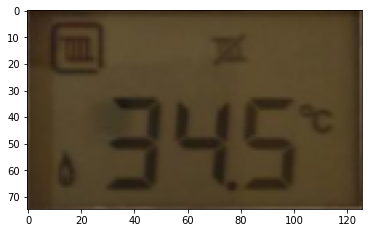

In [61]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

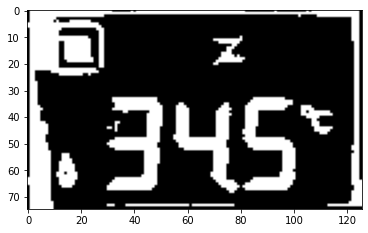

In [67]:
thresh = cv2.threshold(warped, 0, 255,
         cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

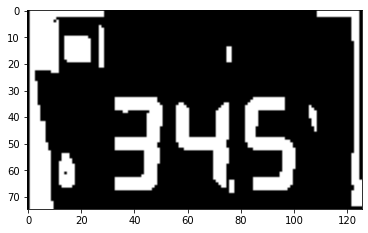

In [68]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

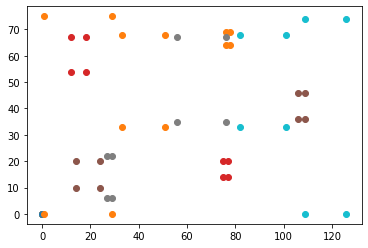

In [84]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    plt.scatter([elem[0][0] in c],[elem[0][1] in c])
    (x, y, w, h) = cv2.boundingRect(c)
    xx = [x, x, x + w, x + w]
    yy = [y, y + h, y, y + h]
    plt.scatter(xx, yy)
    # if the contour is sufficiently large, it must be a digit
    if w >= 15 and (h >= 30 and h <= 40):
        digitCnts.append(c)

In [114]:
print(cv2.boundingRect(c))

(82, 33, 19, 35)


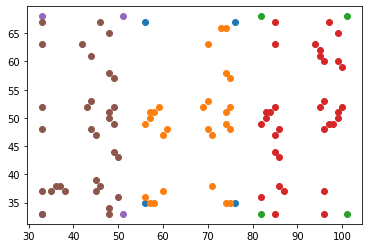

In [87]:
for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    boundingX = [x, x, x + w, x + w]
    boundingY = [y, y + h, y, y + h]
    plt.scatter(boundingX, boundingY)
    
        
    contourX = [elem[0][0] for elem in c]
    contourY = [elem[0][1] for elem in c]
    plt.scatter(contourX, contourY)
    

In [118]:
digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]
digits = []

for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y + h, x:x + w]
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (dW, dH) = (int(w * 0.25), int(h * 0.15))
    dHC = int(h * 0.05)
    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)

    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        # if the total number of non-zero pixels is greater than
        # 50% of the area, mark the segment as "on"
        if total / float(area) > 0.5:
            on[i]= 1
        
            # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

In [120]:
digits

[3, 4, 5]

In [103]:
digits

In [117]:
for elem in [2, 3, 4]:
    print(elem)
    
for (index, elem) in enumerate([2, 3, 4]):
    print(index, elem)
    
(x, y, w) = [1, 2, 3]
print(x, y, w)

2
3
4
0 2
1 3
2 4
1 2 3
